In [1]:
# Importing necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Importing the datasets that will be used
train_set = pd.read_csv("./archive/train.csv")
test_set = pd.read_csv("./archive/test.csv")

# Creating a column to label the train_set & test_set
train_set['data_source'] = "train_set"
test_set['data_source'] = "test_set"

In [3]:
# Adding the missing columns for the testing columns
test_set['count'] = np.nan
test_set['registered'] = np.nan
test_set['casual'] = np.nan

In [4]:
# Concatenating the train_set with the test_set
data = pd.concat([train_set, test_set], axis=0, sort=False)

# Lowercase column names
data.columns = map(str.lower, data.columns)

data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_source
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,train_set
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,train_set
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,train_set
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,train_set
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,train_set


In [5]:
print(f'Train set cols. {", ".join(train_set.columns.tolist())}')
print(f'Test set cols. {", ".join(test_set.columns.tolist())}')
print(f'Difference cols. are {set(train_set.columns) - set(test_set.columns)}')

Train set cols. datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count, data_source
Test set cols. datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, data_source, count, registered, casual
Difference cols. are set()


#### Notes:
Notice that we have three potential target variables. While the count is the exact predictor, we could calculate the casual and registerd to find the count... we'll see how we will calculate the predictor.

In [6]:
# Let's look at the datatype
data.dtypes.sort_values()

season           int64
holiday          int64
workingday       int64
weather          int64
humidity         int64
temp           float64
atemp          float64
windspeed      float64
casual         float64
registered     float64
count          float64
datetime        object
data_source     object
dtype: object

In [7]:
print(f"Total observation (train_set): {train_set.shape[0]}")
print(f"Total observation (test_set): {test_set.shape[0]}")

Total observation (train_set): 10886
Total observation (test_set): 6493


#### Notes:
- The date variable is an object so you will have to change it to a datetype

## Data Cleaning

In [8]:
# Interpolate weather, atemp, humidity
data["weather"] = data["weather"].interpolate(method='time').apply(np.round)
data["temp"] = data["temp"].interpolate(method='time')
data["atemp"] = data["atemp"].interpolate(method='time')
data["humidity"] = data["humidity"].interpolate(method='time').apply(np.round)
data["windspeed"] = data["windspeed"].interpolate(method='time')

In [9]:
def get_dtypes(data, verbose=False):
    """Returns a list: numerical values, object-like columns"""
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics_cols = data.select_dtypes(include=numerics).columns
    object_cols = data.select_dtypes(include='object').columns
    if verbose:
        print('There are {0} numeric cols: {1}\nThere are {2} object cols: {3}\nThere are total cols: {4}'.format
              (len(numerics_cols),numerics_cols, len(object_cols), object_cols, len(data.columns)))
    return [numerics_cols, object_cols]

def get_missing_values(data, cols):
    """Returns a dataframe with missing values (in absolute and percentage format)"""
    
    missing_percent = data[cols].apply(lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False)
    missing_abs = data[cols].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)
    df = pd.DataFrame({'Missing': missing_abs, 'Percent': missing_percent})
    
    # Removing column if correlation is zero
    df = df.loc[~(df==0).all(axis=1)]
    return df

In [10]:
# Separting the numeric and object columnac
num_cols, obj_cols = get_dtypes(data, verbose=False)

# Calculating missing values in our data
missing = get_missing_values(data, num_cols)
missing

,Missing,Percent
count,6493,0.373612
registered,6493,0.373612
casual,6493,0.373612


#### Notes:
- The only missing values are from the predictors... which is how it should!

## Feature Enginnering

#### Notes:
- `extract_dateinfo` function is a fast.ai function. 
    - From a date datatype, it is able to make many calculations!
    - It automates the feature engineering processs.
- `custom_datainfo` function is a function I created.
    - It focuses on renaming or creating abritrary columns (like rush_hour)

In [11]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, start_ref=pd.datetime(1900, 1, 1), extra_attr = True):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [12]:
# Calculating various date variables
data = extract_dateinfo(data, 'datetime', drop=False, time=True)

In [13]:
import calendar

# Conditional on time of day: morning=1, afternoon=2, evening=3, night=4
# Conditional on time of day: spring=1, summer=2, fall=3, winter=4
# Conditional on time of day: clear/few clouds=1, light snow/light rain=2, 
#                             light snow/light rain=3, heavy rain/ice pallets=4

def custom_dateinfo(data):
    data = data.copy()
    data['Year'] = data['Year'].astype('object')
    data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])
    
    dayofweek_name = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    data['Dayofweek'] = data['Dayofweek'].map(dayofweek_name)
    data['Weekofyear'] = data['datetime'].dt.weekofyear
    data['Weekend'] = data['Dayofweek'].map(lambda x: "Yes" if int(x in [5,6]) else "No")
    
    # Creatinga new column that identifies the time of the day (morning, afternoon, evening)
    time_of_day_conds = [
        ((data['Hour'] >=  5) & (data['Hour'] < 12)),
        ((data['Hour'] >=  12) & (data['Hour'] < 17)),
        ((data['Hour'] >=  17) & (data['Hour'] < 21))]
    time_of_days = ["morning", "afternoon", "evening"]
    data['Timeofday'] = np.select(time_of_day_conds, time_of_days, default="night")
    
    # Creating a T/F boolean variable to check whether if it workday
    data['Rush_Workday'] = data['Dayofweek'].map(lambda x: "Yes" if int(x in [0,1,2,3,4]) else "No")
    
    # Creating a T/F boolean variable to check whether it is rush_hour on a workday
    rush_hours = [8, 9, 10, 16, 17, 18]
    data['Rush_Hour'] = data.apply(lambda x: "Yes" if x['Rush_Workday'] == 1 
                                   and x['hour'] in rush_hours else "No", axis=1)
    
    # Modifying the 'season' column
    seasons_to_rename = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
    data['season'] = data['season'].map(seasons_to_rename)
    
    # Modifying the 'weather' column
    weather_to_rename = {1: 'clear/few clouds', 2: 'mist/cloudy', 
                         3: 'light snow/light rain', 4: 'heavy rain/ice pallets'}
    data['weather'] = data['weather'].map(weather_to_rename)
        
    return data

In [14]:
data = custom_dateinfo(data)

In [15]:
def agg_cols(data, col_to_agg, col_by, col_to_name):
    '''Return the total count of a categorical variable segmented by another categorical variable'''
    
    data = data.copy()
    count = data[data['data_source'] == "train_set"].groupby(col_to_agg)[[col_by]].agg(sum)
    count.columns = [col_to_name]
    data = data.join(count, on=col_to_agg)
    return data

In [16]:
data = agg_cols(data, 'season', 'count', 'count_by_season')
data = agg_cols(data, 'season', 'casual', 'casual_by_season')
data = agg_cols(data, 'season', 'registered', 'registered_by_season')
data = agg_cols(data, 'holiday', 'count', 'count_by_holiday')
data = agg_cols(data, 'holiday', 'casual', 'casual_by_holiday')
data = agg_cols(data, 'holiday', 'registered', 'registered_by_holiday')

## Data Visualization

In [17]:
def plot_by_hour(x, predictor, year=None, agg='sum'):
    dd = data.copy()
    if year: dd = dd[dd.datetime.dt.year == year]
    
    by_hour = dd.groupby(['Hour', x])[predictor].agg(agg).unstack()
    by_hour.plot(kind='bar', figsize=(15,3), width=0.9, title="Year = {0}".format(year))

def plot_by_year(agg_attr, predictor, title):
    dd = data.copy()    
    by_year = dd.groupby([agg_attr, 'year'])[predictor].agg('sum').unstack()
    return by_year.plot(kind='bar', figsize=(15,3), width=0.9, title=title)

/Users/alexguanga/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


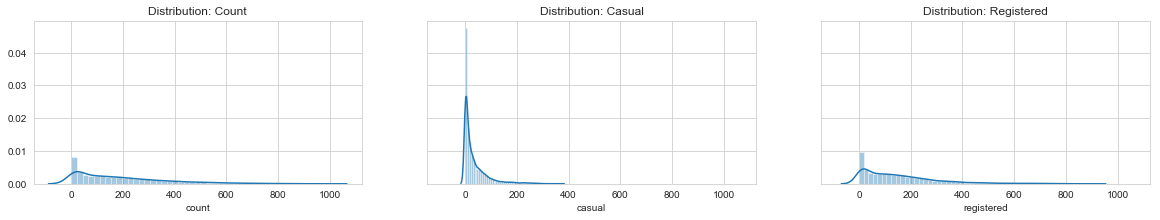

In [18]:
# Visualizing the distribution of potential target variables

fig, axes = plt.subplots(1, 3, figsize = (20, 3), sharex=True, sharey=True)

sns.distplot(train_set['count'], ax=axes[0])
sns.distplot(train_set['casual'], ax=axes[1])
sns.distplot(train_set['registered'], ax=axes[2])

axes[0].set_title('Distribution: Count')
axes[1].set_title('Distribution: Casual')
axes[2].set_title('Distribution: Registered');

/Users/alexguanga/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


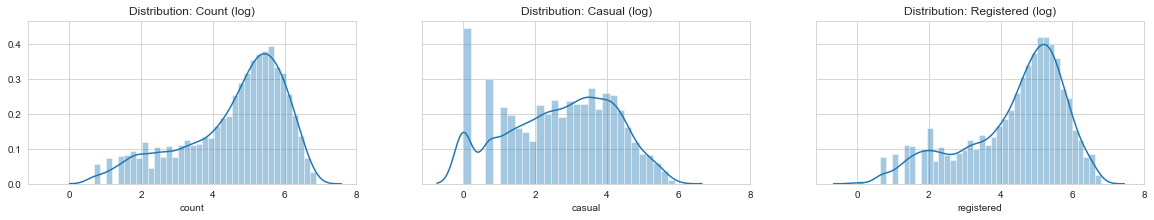

In [19]:
# Visualizing the distribution of our potential target variables

fig, axes = plt.subplots(1, 3, figsize = (20, 3), sharex=True, sharey=True)

sns.distplot(np.log1p(train_set['count']), ax=axes[0])
sns.distplot(np.log1p(train_set['casual']), ax=axes[1])
sns.distplot(np.log1p(train_set['registered']), ax=axes[2])

axes[0].set_title('Distribution: Count (log)')
axes[1].set_title('Distribution: Casual (log)')
axes[2].set_title('Distribution: Registered (log)');

#### Notes:
- For casual, the # of bikes being used has a huge spike in the low-end
- For registered, the distribution is more flat (indicating that registered users are more common at a daily level)
- We are better calculating the log.1p to get a normal distribution. 

A logistic distribution better represents the data when the data is highly skewed. For example, if our data contained values like 0, 1, 10, and 100, well our data will be skewed by the 100. When transforming 0, 1, 10, and 100 in a logistic distrbution, we are normalizing the increases from 0, 1, 10, and 100:

```python
log_transform = [np.log1p(i) for i in [0, 1, 10, 100]]
log_transform    
    
# Output: [0.0, 0.6931471805599453, 2.3978952727983707, 4.61512051684126]
```

/Users/alexguanga/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


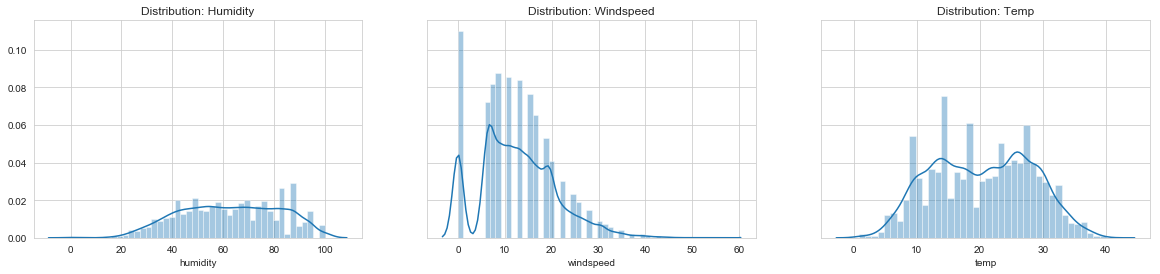

In [20]:
# Lets visualize the distribution of the windspeed, humidity, temp

fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

sns.distplot(data['humidity'], ax=axes[0])
sns.distplot(data['windspeed'], ax=axes[1])
sns.distplot(data['temp'], ax=axes[2])

axes[0].set_title('Distribution: Humidity')
axes[1].set_title('Distribution: Windspeed')
axes[2].set_title('Distribution: Temp');

In [21]:
data.dtypes

datetime                 datetime64[ns]
season                           object
holiday                           int64
workingday                        int64
weather                          object
temp                            float64
atemp                           float64
humidity                          int64
windspeed                       float64
casual                          float64
registered                      float64
count                           float64
data_source                      object
Year                             object
Month                            object
Week                              int64
Day                               int64
Dayofweek                        object
Dayofyear                         int64
Days_in_month                     int64
is_leap_year                       bool
Is_month_end                       bool
Is_month_start                     bool
Is_quarter_end                     bool
Is_quarter_start                   bool


In [ ]:
# Visualizing boxplots
plt.figure(figsize=(12,4))
sns.boxplot(data=train_set[['temp', 'humidity', 'windspeed', 'casual', 'registered', 'count']])
plt.show()

#### Notes:
- Count has the largest variation 

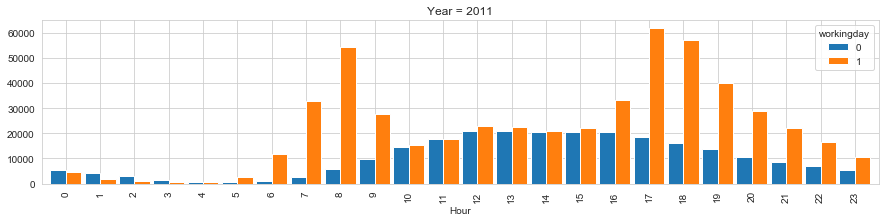

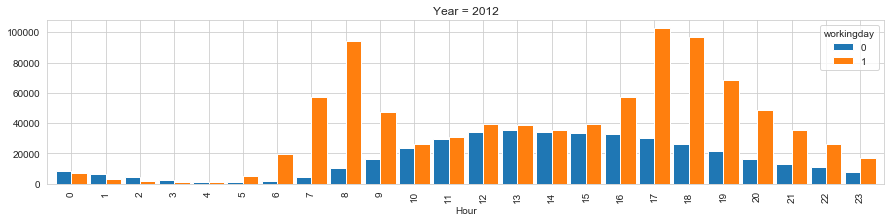

In [23]:
plot_by_hour('workingday', 'count', year=2011)
plot_by_hour('workingday', 'count', year=2012)

#### Notes:
- Notice that we see there is an increase during peak hours in 2011 and 2012. 

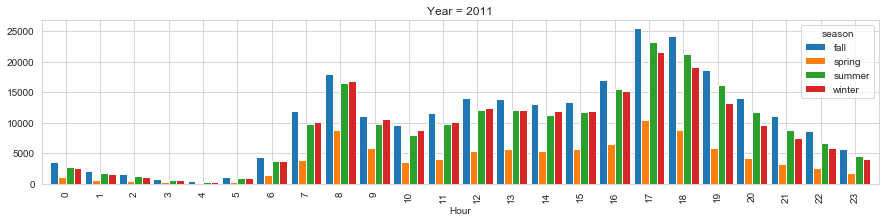

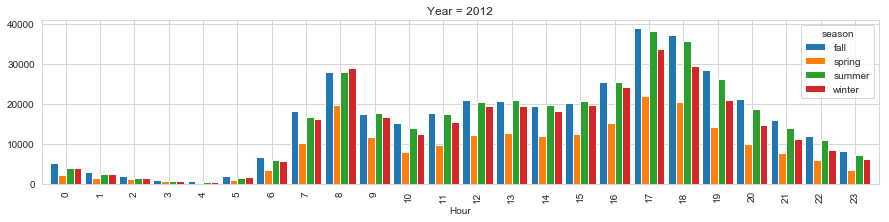

In [24]:
plot_by_hour('season', 'count', year=2011)
plot_by_hour('season', 'count', year=2012)

#### Notes
- Every season has a similar trend except for the spring
    -  1 = spring, 2 = summer, 3 = fall, 4 = winter 


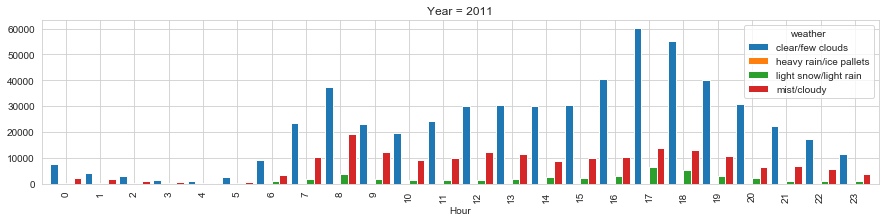

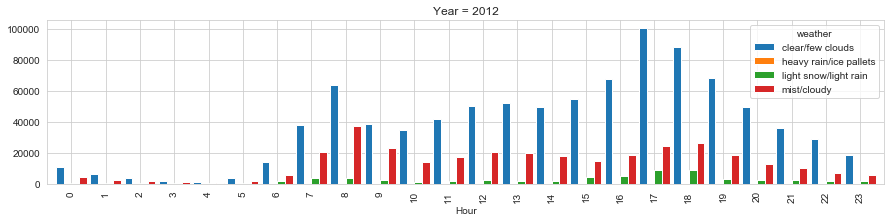

In [25]:
# - weather 
#    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
#    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
#    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
#    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

plot_by_hour('weather', 'count', year=2011)
plot_by_hour('weather', 'count', year=2012)

#### Notes:
- The season and weather visualization states that:
    - All season follow a similar distribution along the x-axis (hours) but spring is has a signficant lesser count
    - A clear weather attracts more people (higher count)

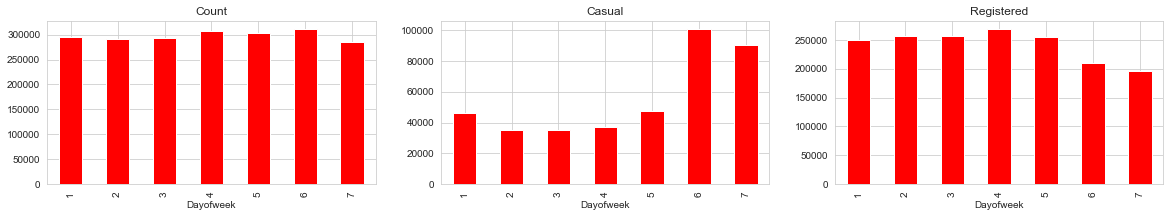

In [26]:
data['Dayofweek'] = data['Dayofweek'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, 
                                           "Friday": 5, "Saturday": 6,  "Sunday": 7})

fig, axs = plt.subplots(1, 3, figsize=(20, 3))

data.groupby('Dayofweek')['count'].sum().sort_index().plot.bar(color='R', ax=axs[0])
data.groupby('Dayofweek')['casual'].sum().sort_index(ascending=True).plot.bar(color='R', ax=axs[1])
data.groupby('Dayofweek')['registered'].sum().sort_index(ascending=True).plot.bar(color='R', ax=axs[2])

axs[0].set_title('Count')
axs[1].set_title('Casual')
axs[2].set_title('Registered');

#### Notes:
- Casual users are more common in the weekend while registered users are more common in the weekdays

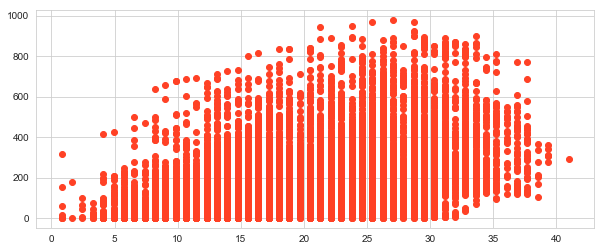

In [27]:
# Scatter plot for temp
plt.figure(figsize=(10, 4))
plt.scatter(x="temp",y="count",data=data,color='#ff4125')
plt.show()

## Data Cleaning

In [28]:
np.warnings.filterwarnings('ignore')

data['casual_log'] = np.log1p(data['casual'])
data['registered_log'] = np.log1p(data['registered'])
data['count_log'] = np.log1p(data['count'])

data.drop(['casual', 'registered', 'count'], axis=1, inplace=True)

## Model Selection: Correlation

In [29]:
PREDICTORS = ['casual_log', 'registered_log', 'count_log']

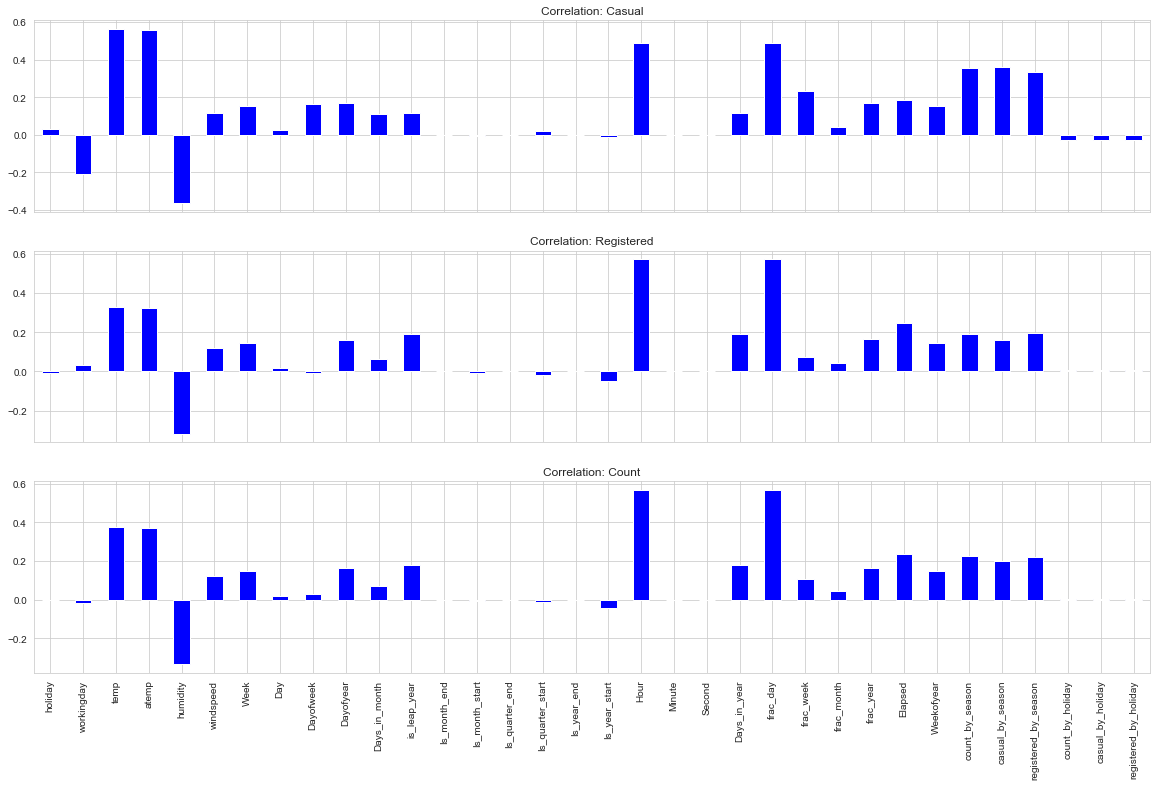

In [30]:
# Correlation among the variables and the potential predictors
corrs = data.corr()

fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharex=True)
corrs['casual_log'].drop(PREDICTORS).plot.bar(color = 'b', ax=axs[0], title="Correlation: Casual");
corrs['registered_log'].drop(PREDICTORS).plot.bar(color = 'b', ax=axs[1], title="Correlation: Registered");
corrs['count_log'].drop(PREDICTORS).plot.bar(color = 'b', ax=axs[2], title="Correlation: Count");

#### Notes:
- The top correlated variables with the predictors are Hour, Days_in_year, frac_day, Elapsed
- The correlation values are similar throughout the three predictors with the exception of workingday

In [31]:
def correlation(data, corr_by, remove_by=None, top_values=10):
    data = data.copy()
    corrs = data.corr()
    if remove_by is None: remove_by = [corr_by]     
        
    vals = corrs[corr_by].drop(remove_by).sort_values().values
    col = corrs[corr_by].drop(remove_by).sort_values().index
    
    df = pd.DataFrame({'columns': col, 'values': vals})
    df['abs_vals'] = abs(df['values'])
    
    return df.sort_values(by='abs_vals', ascending=False)[:top_values]

In [32]:
correlation(data, 'casual_log', remove_by=PREDICTORS)

,columns,values,abs_vals
28,temp,0.562596,0.562596
27,atemp,0.559950,0.559950
26,frac_day,0.486784,0.486784
25,Hour,0.486784,0.486784
0,humidity,-0.366263,0.366263
24,casual_by_season,0.362035,0.362035
23,count_by_season,0.353901,0.353901
22,registered_by_season,0.332353,0.332353
21,frac_week,0.232573,0.232573
1,workingday,-0.208715,0.208715


In [33]:
correlation(data, 'registered_log', remove_by=PREDICTORS)

,columns,values,abs_vals
28,Hour,0.572704,0.572704
27,frac_day,0.572704,0.572704
26,temp,0.330701,0.330701
25,atemp,0.326022,0.326022
0,humidity,-0.317667,0.317667
24,Elapsed,0.246150,0.246150
23,registered_by_season,0.196908,0.196908
22,count_by_season,0.192971,0.192971
21,is_leap_year,0.189234,0.189234
20,Days_in_year,0.189234,0.189234


In [34]:
correlation(data, 'count_log', remove_by=PREDICTORS)

,columns,values,abs_vals
28,Hour,0.570638,0.570638
27,frac_day,0.570638,0.570638
26,temp,0.376587,0.376587
25,atemp,0.372167,0.372167
0,humidity,-0.333158,0.333158
24,Elapsed,0.237444,0.237444
23,count_by_season,0.223818,0.223818
22,registered_by_season,0.223127,0.223127
21,casual_by_season,0.200552,0.200552
20,is_leap_year,0.178236,0.178236


## Data Cleaning: Removing Columns

#### Notes:
- After checking the correlations values, there are a couple of columns that represent the same information. Some of the redudant columns are:
    - Hour and frac_day
    - temp and atemp
    - Days_in_year and is_leap_year

In [35]:
data.drop(['frac_day', 'atemp', 'Days_in_year'], axis=1, inplace=True)

## Data Cleaning: Dummies

To encode the categorical variables, we will be using the `pd.get_dummies()`


In [36]:
from sklearn import preprocessing

# Extracting the columns that will be encoded
object_cols = data.select_dtypes('object').columns.tolist()
bool_cols = data.select_dtypes('bool').columns.tolist()
encoded_cols = object_cols+bool_cols

# Copying the dataframe to create encoders
data = data.copy()

# Encoding the object/bool columns
data = pd.get_dummies(data, columns=encoded_cols, drop_first=True)

## Feature Engineering

In [37]:
# Grouping the columns' datatype 
data.columns.to_series().groupby(data.dtypes).groups

{dtype('<M8[ns]'): Index(['datetime'], dtype='object'),
 dtype('uint8'): Index(['season_spring', 'season_summer', 'season_winter',
        'weather_heavy rain/ice pallets', 'weather_light snow/light rain',
        'weather_mist/cloudy', 'data_source_train_set', 'Year_2012',
        'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan', 'Month_Jul',
        'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
        'Month_Sep', 'Timeofday_evening', 'Timeofday_morning',
        'Timeofday_night', 'is_leap_year_True', 'Is_month_end_True',
        'Is_month_start_True', 'Is_quarter_end_True', 'Is_quarter_start_True',
        'Is_year_end_True', 'Is_year_start_True'],
       dtype='object'),
 dtype('int64'): Index(['holiday', 'workingday', 'humidity', 'Week', 'Day', 'Dayofweek',
        'Dayofyear', 'Days_in_month', 'Hour', 'Minute', 'Second', 'Weekofyear'],
       dtype='object'),
 dtype('float64'): Index(['temp', 'windspeed', 'frac_week', 'frac_month', 'frac_year', 'Elapsed',
 

## Data Modeling

In [38]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
import xgboost as xgb
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# There are some internal error with Xgboost, this is the way around it
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/alexguanga/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [39]:
# Will need the test_datetime when we are submitting the predictions
test_datetime = data.loc[data['count_log'].isnull(), "datetime"]

# Changing columns names to lowercase
data.columns = map(str.lower, data.columns)

# Extracting the training set
train_on = data[data['data_source_train_set'] == 1]

# Calculating the testing set for the two dataframes
test_on = data[data['data_source_train_set'] == 0]

# Columns that will be dropped from the dataset (predictors & time)
cols_to_drop = ['count_log', 'registered_log', 'casual_log', 'datetime']
train_on.drop(cols_to_drop, axis=1, inplace=True)
test_on.drop(cols_to_drop, axis=1, inplace=True)

In [40]:
def get_train_labels(data, predictors):
    '''Returns the target variable for the training set'''

    labels = [np.array(list(data.loc[data[p].notnull(), p])) for p in predictors]
    return labels

In [41]:
# Splitting the dataset into a training and testing set

from sklearn.model_selection import train_test_split

# Extracting the target variable without encoding(we will have 3 for this dataset)
train_label_count, train_label_reg, train_label_cas = get_train_labels(
    data, ['count_log', 'registered_log', 'casual_log'])

x_train, x_test, y_train, y_test = train_test_split(train_on, train_label_count, test_size=0.25, random_state=42)
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(train_on, train_label_cas, test_size=0.25, random_state=42)
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(train_on, train_label_reg, test_size=0.25, random_state=42)

In [42]:
sum_count = train_set['count'].sum()
sum_casual = train_set['casual'].sum()
sum_registered = train_set['registered'].sum()

# A rough estimate of our weights to casual & registered
print(f"Casual to Count Ratio: {sum_casual/sum_count:.2f}")
print(f"Registered to Count Ratio: {sum_registered/sum_count:.2f}")

Casual to Count Ratio: 0.19
Registered to Count Ratio: 0.81


In [43]:
# Custom scorer that will be used to measure performance
def rmse(actual, predicted):        
    assert len(actual) == len(predicted)
    return np.sqrt(np.mean(np.power((actual)-(predicted), 2)))

def rmse_log(actual, predicted):
    assert len(actual) == len(predicted)
    sle = (np.power(np.log(np.array((actual))+1) - np.log(np.array(np.abs(predicted))+1), 2))
    msle = np.mean(sle)
    return np.sqrt(msle)

In [44]:
rmsle_scorer = make_scorer(rmse_log, greater_is_better=False)
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [45]:
MODELS = {"Random Forest": RandomForestRegressor(n_jobs=-1),
          "XGBoost": xgb.XGBRegressor(n_jobs=-1), 
          "Gradient Boosting": GradientBoostingRegressor(),
          "AdaBoost": AdaBoostRegressor(),
          "Bagging": BaggingRegressor(),
          "SVR": SVR()
         }

In [46]:
def run_models_cv(data, labels, model, cv=10):
    cv_score = cross_val_score(model, data, labels, cv=cv, scoring=rmse_scorer)
    print(f"10Fold CV RMLSE - Mean: {round(np.abs(cv_score.mean()), 4)}, Std. deviation: {round(cv_score.std(), 4)}")
    return np.abs(cv_score.mean())
    

In [47]:
# Quickly training the model for comparision

rmsle_history = []
for model_name, model in MODELS.items():
    print(f"{model_name}")
    rmsle_perf = run_models_cv(x_train, y_train, model)
    rmsle_history.append(rmsle_perf)
    print("----------")
    

Random Forest
10Fold CV RMLSE - Mean: 0.3245, Std. deviation: 0.016
----------
XGBoost
10Fold CV RMLSE - Mean: 0.3608, Std. deviation: 0.0128
----------
Gradient Boosting
10Fold CV RMLSE - Mean: 0.3607, Std. deviation: 0.0113
----------
AdaBoost
10Fold CV RMLSE - Mean: 0.6457, Std. deviation: 0.0177
----------
Bagging
10Fold CV RMLSE - Mean: 0.3209, Std. deviation: 0.0165
----------
SVR
10Fold CV RMLSE - Mean: 1.444, Std. deviation: 0.0533
----------


In [ ]:
# Visualizing baseline scores
d = {"Modeling Algo": list(MODELS.keys()), "RMSLE": rmsle_history}
rmsle_frame = pd.DataFrame(d)

sns.factorplot(y='Modeling Algo', x='RMSLE', data=rmsle_frame, kind='bar', size=5, aspect=2)
plt.show()

#### Notes:
- `factorplot` do an excellent way of creating chart that could be easily manipulated and tweak to include additional features... it's an effective method to automate the visualization with seaborn's API!

#### Notes
- I would like to use all three target variables to make predictions.
- However, finding the appropriate weight to each of the target variables is more complicated than it seems.
- I am going to make two prediction (to gain a better understanding of their performance)
    1. Add the Casual + Registered predictions
    2. Use the Count predictions

In [49]:
def feat_df(feats, cols):
    return pd.DataFrame(feats, index=cols, columns=['importance']).sort_values('importance', ascending=False)

def random_search(model, params, train_on, train_labels, cv=5):
    train_on = train_on.values
    rs = RandomizedSearchCV(model, param_distributions=params, scoring=rmse_scorer, cv=cv, )
    
    # Train the model
    rs.fit(train_on, train_labels)
    return rs

def get_predict(model, train_on, train_labels, test_on, test_ids=None, return_df=False):
    model.fit(train_on, train_labels)
    predict = model.predict(test_on)
    predict = np.exp(predict) - 1
    
    if return_df:
        sub = pd.DataFrame({'datetime': test_ids, 'count': predict.astype(int)})
                           
        return sub
                           
    return predict

In [50]:
def run_model(rs_model, train_model, params, train_on, train_label, predict=False):
    # Creating a copy of the dataframe
    train_on = train_on.copy()
    
    columns = train_on.columns
    
    # Creating two dictionaries: parameters that were found best via Random Search & the model trained with the data
    model_searches, model_trained = {}, {}
        
    # Finding the best parameters among the hyperparameter that were passed
    model_search_1 = random_search(rs_model, params, train_on, train_label, cv=5)
    
    # Printing the best score & parameters
    best_params, best_score = model_search_1.best_params_, model_search_1.best_score_
    print(f"Best Params. (all-in columns): {best_params}")
    print(f"Best Score for (all-in columns): {np.abs(best_score):.2f}")
    
    # Saving the parameters to the dictionary
    model_searches["Model-Search_All"] = model_search_1

    # Training the model
    model = train_model(**best_params)
    model.fit(train_on, train_label)
    model_trained['Model-Search_All'] = model
    
    # Now, we will train the model only with the most important features
    imp_cols = feat_df(model.feature_importances_, columns)
    imp_cols = imp_cols[imp_cols['importance'] > 0].index
    
    # Redoing the process but with variables that had a higher importance than 1
    model_search_2 = random_search(rs_model, params, train_on[imp_cols], train_label, cv=5)
    best_params, best_score = model_search_2.best_params_, model_search_2.best_score_
    print(f"Best Params. for (feat. selection): {best_params}")
    print(f"Best Score for (feat. selection): {np.abs(best_score):.2f}\n")
    
    # Saving the parameters of the model with important features to the dictionary
    model_searches['Model-Search_Features'] = model_search_2

    # Training the model with the optimal features
    model = train_model(**best_params)
    model.fit(train_on, train_label)
    model_trained['Model-Search_Features'] = model

    
    return [model_searches, model_trained, imp_cols] 

In [ ]:
Y_LABELS = {"y_train": y_train, 
            "y_train_c": y_train_c, 
            "y_train_r": y_train_r
           }

### Model: XGBRegressor

In [51]:
xgb_model_1 = xgb.XGBRegressor(n_jobs=-1, random_state=0)
xgb_model_2 = xgb.XGBRegressor
xgb_params = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
              "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight": [1, 3, 5, 7],
              "gamma": [0.0, 0.1, 0.2 , 0.3, 0.4],
              "colsample_bytree": [0.3, 0.4, 0.5 , 0.7]}

In [53]:
# Training different models to get the best 

results_d = {}

for label_name, label in Y_LABELS.items():
    model_rs, model_trained, imp_cols = run_model(xgb_model_1, xgb_model_2, xgb_params, x_train, label)
    results_d[label_name] = [model_rs, model_trained, imp_cols]

Best Params. (all-in columns): {'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.5}
Best Score for (all-in columns): 0.29
Best Params. for (feat. selection): {'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.5}
Best Score for (feat. selection): 0.29

Best Params. (all-in columns): {'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.3}
Best Score for (all-in columns): 0.46
Best Params. for (feat. selection): {'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.4}
Best Score for (feat. selection): 0.46

Best Params. (all-in columns): {'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.4}
Best Score for (all-in columns): 0.28
Best Params. for (feat. selection): {'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 

In [54]:
results_d.keys()

dict_keys(['y_train', 'y_train_c', 'y_train_r'])

In [ ]:
# Storing the dataframe dictionary
d = {}

In [55]:
# Models that were trained in the for loop above

model_all = results_d['y_train'][1]['Model-Search_All']
model_feat = results_d['y_train'][1]['Model-Search_Features']

model_all_c = results_d['y_train_c'][1]['Model-Search_All']
model_feat_c = results_d['y_train_c'][1]['Model-Search_Features']

model_all_r = results_d['y_train_r'][1]['Model-Search_All']
model_feat_r = results_d['y_train_r'][1]['Model-Search_Features']

In [88]:
# Quick-check on the testing set (a part of the training set)

y_predict_xgb = get_predict(model_all, x_train, y_train, x_test)
rmse_score = rmse(np.expm1(y_test), y_predict_xgb)
print(f"Testing Score: {rmse_score:.2f}")

Testing Score: 39.07


In [59]:
# Let's test it on the actual test_set
predict = get_predict(model_all, train_on, train_label_count, test_on, test_datetime, return_df=True)

# Extracting to csv
d['model_xgb_all'] = predict
#predict.to_csv("./saved_submissions/xgb-all_12-27-18.csv", index=False) #0.41202

In [60]:
# Let's test it on the actual test_set
predict = get_predict(model_feat, train_on, train_label_count, test_on, test_datetime, return_df=True)

# Extracting to csv
d['model_xgb_feat'] = predict
#predict.to_csv("./saved_submissions/xgb-feat_12-27-18.csv", index=False)#0.42347

In [76]:
# Let view the results if we add reg + casual
predict_cas = get_predict(model_all_c, train_on, train_label_cas, test_on, test_datetime, return_df=True)
predict_reg = get_predict(model_all_r, train_on, train_label_reg, test_on, test_datetime, return_df=True)

# Aggregating the predictions
predict = (predict_cas['count'] + predict_reg['count']).astype(int)
predict = pd.DataFrame({'datetime': test_datetime, 'count': predict})

d['model_xgb_agg_all'] = predict
predict.to_csv('./saved_submissions/xgb_all-sum_1-2-18.csv', index=False)

# Scoring -> 0.41332

In [77]:
# Let view the results if we add reg + casual
predict_cas = get_predict(model_feat_c, train_on, train_label_cas, test_on, test_datetime, return_df=True)
predict_reg = get_predict(model_feat_r, train_on, train_label_reg, test_on, test_datetime, return_df=True)

# Aggregating the predictions
predict = (predict_cas['count'] + predict_reg['count']).astype(int)
predict = pd.DataFrame({'datetime': test_datetime, 'count': predict})

d['model_xgb_agg_feat'] = predict
predict.to_csv('./saved_submissions/xgb_feat-sum_1-2-18.csv', index=False)

# Scoring -> 0.41574

#### Scoring Performance:
- `model_xgb_all`: 0.41202
- `model_xgb_feat`: 0.42347
- `model_xgb_agg_all`: 0.41332
- `model_xgb_agg_feat`: 0.41574

### Model: GradientBoostingRegressor

In [78]:
gb_model_1 = GradientBoostingRegressor()
gb_model_2 = GradientBoostingRegressor
gb_params = {"learning_rate": [0.10, 0.15, 0.20, 0.25, 0.30],
             "n_estimators": [100, 125, 150, 175, 200],
             "max_depth": np.linspace(1, 32, 32, endpoint=True),
             "min_samples_split": np.linspace(0.1, 1.0, 10, endpoint=True),
             "min_samples_leaf": [2, 4, 6, 8, 10, 12, 14]}

In [79]:
results_gb = {}

for label_name, label in Y_LABELS.items():
    model_rs, model_trained, imp_cols = run_model(gb_model_1, gb_model_2, gb_params, x_train, label)
    results_gb[label_name] = [model_rs, model_trained, imp_cols]

Best Params. (all-in columns): {'n_estimators': 125, 'min_samples_split': 0.1, 'min_samples_leaf': 4, 'max_depth': 28.0, 'learning_rate': 0.3}
Best Score for (all-in columns): 0.29
Best Params. for (feat. selection): {'n_estimators': 175, 'min_samples_split': 0.1, 'min_samples_leaf': 4, 'max_depth': 18.0, 'learning_rate': 0.15}
Best Score for (feat. selection): 0.29

Best Params. (all-in columns): {'n_estimators': 200, 'min_samples_split': 0.1, 'min_samples_leaf': 10, 'max_depth': 15.0, 'learning_rate': 0.15}
Best Score for (all-in columns): 0.45
Best Params. for (feat. selection): {'n_estimators': 100, 'min_samples_split': 0.1, 'min_samples_leaf': 12, 'max_depth': 16.0, 'learning_rate': 0.2}
Best Score for (feat. selection): 0.46

Best Params. (all-in columns): {'n_estimators': 100, 'min_samples_split': 0.4, 'min_samples_leaf': 14, 'max_depth': 11.0, 'learning_rate': 0.3}
Best Score for (all-in columns): 0.31
Best Params. for (feat. selection): {'n_estimators': 150, 'min_samples_split

In [80]:
model_all = results_gb['y_train'][1]['Model-Search_All']
model_feat = results_gb['y_train'][1]['Model-Search_Features']

model_all_c = results_gb['y_train_c'][1]['Model-Search_All']
model_feat_c = results_gb['y_train_c'][1]['Model-Search_Features']

model_all_r = results_gb['y_train_r'][1]['Model-Search_All']
model_feat_r = results_gb['y_train_r'][1]['Model-Search_Features']


In [85]:
# Let's test it on the actual test_set
predict = get_predict(model_all, train_on, train_label_count, test_on, test_datetime, return_df=True)
d['model_gb_all'] = predict
#predict.to_csv("./saved_submissions/gb-all_1-2-18.csv", index=False) #0.43123

In [84]:
# Extracting to csv
predict = get_predict(model_feat, train_on, train_label_count, test_on, test_datetime, return_df=True)
d['model_gb_feat'] = predict
#predict.to_csv("./saved_submissions/gb-feat_1-2-18.csv", index=False) #0.44574

In [87]:
# Let view the results if we add reg + casual
predict_cas = get_predict(model_all_c, train_on, train_label_cas, test_on, test_datetime, return_df=True)
predict_reg = get_predict(model_all_r, train_on, train_label_reg, test_on, test_datetime, return_df=True)

# Aggregating the predictions
predict = (predict_cas['count'] + predict_reg['count']).astype(int)
predict = pd.DataFrame({'datetime': test_datetime, 'count': predict})

d['model_gb_agg_all'] = predict
predict.to_csv('./saved_submissions/gb_all-sum_1-2-18.csv', index=False) # Scoring -> 0.44070

In [88]:
# Let view the results if we add reg + casual
predict_cas = get_predict(model_feat_c, train_on, train_label_cas, test_on, test_datetime, return_df=True)
predict_reg = get_predict(model_feat_r, train_on, train_label_reg, test_on, test_datetime, return_df=True)

# Aggregating the predictions
predict = (predict_cas['count'] + predict_reg['count']).astype(int)
predict = pd.DataFrame({'datetime': test_datetime, 'count': predict})

d['model_gb_agg_feat'] = predict
predict.to_csv('./saved_submissions/gb_feat-sum_1-2-18.csv', index=False) # Scoring -> 0.45243

#### Scoring Performance:
- `model_gb_all`: 0.43123
- `model_gb_feat`: 0.44574
- `model_gb_agg_all`: 0.44070
- `model_gb_agg_feat`: 0.45243

### Model: RandomForestRegressor

In [89]:
rf_model_1 = RandomForestRegressor(n_jobs=-1)
rf_model_2 = RandomForestRegressor
rf_params = {"n_estimators": [int (x) for x in np.linspace(start=200, stop=1000, num=9, endpoint=True)],
             "max_features": ['auto', 'sqrt'],
             "max_depth": np.linspace(5, 32, 28, endpoint=True),
             "min_samples_split": np.linspace(0.1, 1.0, 10, endpoint=True),
             "min_samples_leaf": [4, 6, 8, 10, 12, 20]}

In [90]:
results_rf = {}

for label_name, label in Y_LABELS.items():
    model_rs, model_trained, imp_cols = run_model(rf_model_1, rf_model_2, rf_params, x_train, label)
    results_rf[label_name] = [model_rs, model_trained, imp_cols]

Best Params. (all-in columns): {'n_estimators': 600, 'min_samples_split': 0.30000000000000004, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 27.0}
Best Score for (all-in columns): 0.99
Best Params. for (feat. selection): {'n_estimators': 400, 'min_samples_split': 0.1, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 25.0}
Best Score for (feat. selection): 0.69

Best Params. (all-in columns): {'n_estimators': 800, 'min_samples_split': 0.1, 'min_samples_leaf': 20, 'max_features': 'auto', 'max_depth': 27.0}
Best Score for (all-in columns): 0.75
Best Params. for (feat. selection): {'n_estimators': 700, 'min_samples_split': 0.1, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 5.0}
Best Score for (feat. selection): 0.78

Best Params. (all-in columns): {'n_estimators': 900, 'min_samples_split': 0.1, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 17.0}
Best Score for (all-in columns): 0.69
Best Params. for (feat. selection): {'n_estimators':

#### Notes:
- For some reason, Random Forest has terrible performance. This should something we look into!

In [98]:
model_all_rf = results_rf['y_train'][1]['Model-Search_All']
model_feat = results_rf['y_train'][1]['Model-Search_Features']

model_all_c = results_rf['y_train_c'][1]['Model-Search_All']
model_feat_c = results_rf['y_train_c'][1]['Model-Search_Features']

model_all_r = results_rf['y_train_r'][1]['Model-Search_All']
model_feat_r = results_rf['y_train_r'][1]['Model-Search_Features']


In [99]:
# Let's test it on the actual test_set
predict = get_predict(model_all, train_on, train_label_count, test_on, test_datetime, return_df=True)
d['model_rf_all'] = predict
predict.to_csv("./saved_submissions/rf-all_1-2-18.csv", index=False) 

In [100]:
# Extracting to csv
predict = get_predict(model_feat, train_on, train_label_count, test_on, test_datetime, return_df=True)
d['model_rf_feat'] = predict
predict.to_csv("./saved_submissions/rf-feat_1-2-18.csv", index=False) 

In [101]:
# Let view the results if we add reg + casual
predict_cas = get_predict(model_all_c, train_on, train_label_cas, test_on, test_datetime, return_df=True)
predict_reg = get_predict(model_all_r, train_on, train_label_reg, test_on, test_datetime, return_df=True)

# Aggregating the predictions
predict = (predict_cas['count'] + predict_reg['count']).astype(int)
predict = pd.DataFrame({'datetime': test_datetime, 'count': predict})

d['model_rf_agg_all'] = predict
predict.to_csv('./saved_submissions/rf_all-sum_1-2-18.csv', index=False) # Scoring -> 0.44070

In [102]:
# Let view the results if we add reg + casual
predict_cas = get_predict(model_feat_c, train_on, train_label_cas, test_on, test_datetime, return_df=True)
predict_reg = get_predict(model_feat_r, train_on, train_label_reg, test_on, test_datetime, return_df=True)

# Aggregating the predictions
predict = (predict_cas['count'] + predict_reg['count']).astype(int)
predict = pd.DataFrame({'datetime': test_datetime, 'count': predict})

d['model_rf_agg_feat'] = predict
predict.to_csv('./saved_submissions/rf_feat-sum_1-2-18.csv', index=False) # Scoring -> 0.45243

#### Scoring Performance:
- `model_rf_all`: 0.99251
- `model_rf_feat`: 0.75609
- `model_rf_agg_all`: 0.72469
- `model_rf_agg_feat`: 1.04207

### Model: Advanced (Combining Models)

In [119]:
results_d.keys()

dict_keys(['y_train', 'y_train_c', 'y_train_r'])

In [125]:
xgb_model_all = results_d['y_train'][1]['Model-Search_All']
xgb_model_features = results_d['y_train'][1]['Model-Search_Features']
gb_model_all = results_gb['y_train'][1]['Model-Search_All']
gb_model_features = results_gb['y_train'][1]['Model-Search_Features']

In [126]:
y_predict_xgb_all = get_predict(xgb_model_all, x_train, y_train, x_test)
y_predict_xgb_feats = get_predict(xgb_model_features, x_train, y_train, x_test)
y_predict_gb_all = get_predict(gb_model_all, x_train, y_train, x_test)
y_predict_gb_feats = get_predict(gb_model_features, x_train, y_train, x_test)

In [129]:
y_test = np.expm1(y_test)
instances = np.arange(0, len(y_test), 1)

In [146]:
y_test_d = {"ground_truth": y_test, "xgb_all": y_predict_xgb_all, "xgb_feats": y_predict_xgb_feats,
            "gb_all": y_predict_gb_all, "gb_feats": y_predict_gb_feats}

y_test_df = pd.DataFrame(y_test_d)

In [149]:
y_test_df['diff_xgb_all']  = y_test_df['ground_truth'] - y_test_df['xgb_all']
y_test_df['diff_xgb_feats'] = y_test_df['ground_truth'] - y_test_df['xgb_feats']
y_test_df['diff_gb_all'] = y_test_df['ground_truth'] - y_test_df['gb_all']
y_test_df['diff_gb_feats'] = y_test_df['ground_truth'] - y_test_df['gb_feats']

In [153]:
y_test_df['avg'] = (y_test_df['xgb_all']+y_test_df['xgb_feats']+y_test_df['gb_all']+y_test_df['gb_feats'])/4

In [156]:
rmse_score = rmse(y_test_df['ground_truth'], y_test_df['avg'])
rmse_score

36.37573392030498

In [157]:
d.keys()

dict_keys(['model_xgb_all', 'model_xgb_feat', 'model_xgb_agg_all', 'model_xgb_agg_feat', 'model_gb_feat', 'model_gb_all', 'model_gb_agg_feat', 'model_gb_agg_all', 'model_rf_all', 'model_rf_feat', 'model_rf_agg_all', 'model_rf_agg_feat'])

In [161]:
# Averaging the actual test predictions
weighted_pred = (d['model_xgb_all']['count'] + d['model_xgb_feat']['count'] + 
                 d['model_gb_feat']['count'] + d['model_gb_all']['count'])/4

In [163]:
predict = pd.DataFrame({'datetime': test_datetime, 'count': weighted_pred})
predict.to_csv('./saved_submissions/weighted_1-3-18.csv', index=False) # Scoring -> 0.41143

#### Scoring Performance
- `Weighted Average`: 0.41143